# スマホゲームのTVCMの効果を推定する
- データセット: [岩波データサイエンス Vol.3](https://www.iwanami.co.jp/book/b243764.html)
- [森本さん資料](https://dena-analytics.slack.com/archives/C0BD62N21/p1582080304048900()

In [1]:
import os
from time import time
import warnings

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

warnings.filterwarnings('ignore')
np.random.seed(123)
pd.set_option('display.max_columns', 100)
plt.style.use('seaborn-dark')

save_dir = 'sample_tvcm'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [2]:
csv_url = 'https://raw.githubusercontent.com/iwanami-datascience/vol3/master/kato%26hoshino/q_data_x.csv'

print("Loading dataset...")
t0 = time()
df = pd.read_csv(csv_url)
print(f'End in {time() - t0 :.2f}s.')

print(f'shape: {df.shape}')
display(df.head(2))

Loading dataset...
End in 0.26s.
shape: (10000, 35)


,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,job_dummy2,job_dummy3,job_dummy4,job_dummy5,job_dummy6,job_dummy7,job_dummy8,inc,pmoney,fam_str_dummy1,fam_str_dummy2,fam_str_dummy3,fam_str_dummy4,fam_str_dummy5,child_dummy,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount
0,0,0,0,0,0,1,44.5,1,1,1,0,0,0,0,0,0,0,249.5,0.0,0,0,1,0,0,1,0,0,0,0,0,1,0,33.427600,0,0
1,0,0,0,1,0,0,34.5,1,1,1,0,0,0,0,0,0,0,800.0,12.5,0,0,1,0,0,1,0,0,0,0,0,1,0,31.542862,0,0


# Check dataset

In [3]:
print(df.columns)

Index(['cm_dummy', 'gamedummy', 'area_kanto', 'area_keihan', 'area_tokai',
       'area_keihanshin', 'age', 'sex', 'marry_dummy', 'job_dummy1',
       'job_dummy2', 'job_dummy3', 'job_dummy4', 'job_dummy5', 'job_dummy6',
       'job_dummy7', 'job_dummy8', 'inc', 'pmoney', 'fam_str_dummy1',
       'fam_str_dummy2', 'fam_str_dummy3', 'fam_str_dummy4', 'fam_str_dummy5',
       'child_dummy', 'T', 'F1', 'F2', 'F3', 'M1', 'M2', 'M3', 'TVwatch_day',
       'gamesecond', 'gamecount'],
      dtype='object')


In [4]:
treat_col = 'cm_dummy'
ps_col = 'propensity'
outcome_col = 'gamedummy'  # 'gamesecond', 'gamecount'

In [5]:
cnt_tr = len(df[df[treat_col]==1])
cnt_ct = len(df[df[treat_col]==0])

print(f'# of samples (treatment): {cnt_tr}')
print(f'# of samples (control):   {cnt_ct}')

# of samples (treatment): 4144
# of samples (control):   5856


# Preprocessing

In [6]:
# inc, pmoney, age: categorical -> one-hot encoding
biased_df = df.copy()
cols = ['inc', 'pmoney', 'age']
for col in cols:
    dummy_df = pd.get_dummies(biased_df[col], prefix=col, drop_first=True)
    biased_df = pd.concat([biased_df, dummy_df], axis=1)
    biased_df = biased_df.drop(col, axis=1)
print(biased_df.columns)
biased_df.head(2)

Index(['cm_dummy', 'gamedummy', 'area_kanto', 'area_keihan', 'area_tokai',
       'area_keihanshin', 'sex', 'marry_dummy', 'job_dummy1', 'job_dummy2',
       'job_dummy3', 'job_dummy4', 'job_dummy5', 'job_dummy6', 'job_dummy7',
       'job_dummy8', 'fam_str_dummy1', 'fam_str_dummy2', 'fam_str_dummy3',
       'fam_str_dummy4', 'fam_str_dummy5', 'child_dummy', 'T', 'F1', 'F2',
       'F3', 'M1', 'M2', 'M3', 'TVwatch_day', 'gamesecond', 'gamecount',
       'inc_103.0', 'inc_151.5', 'inc_249.5', 'inc_349.5', 'inc_449.5',
       'inc_549.5', 'inc_649.5', 'inc_749.5', 'inc_800.0', 'pmoney_1.0',
       'pmoney_2.0', 'pmoney_3.3', 'pmoney_4.0', 'pmoney_6.5', 'pmoney_9.0',
       'pmoney_12.5', 'pmoney_17.5', 'pmoney_20.0', 'age_24.5', 'age_34.5',
       'age_44.5', 'age_54.5', 'age_60.0'],
      dtype='object')


,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,sex,marry_dummy,job_dummy1,job_dummy2,job_dummy3,job_dummy4,job_dummy5,job_dummy6,job_dummy7,job_dummy8,fam_str_dummy1,fam_str_dummy2,fam_str_dummy3,fam_str_dummy4,fam_str_dummy5,child_dummy,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount,inc_103.0,inc_151.5,inc_249.5,inc_349.5,inc_449.5,inc_549.5,inc_649.5,inc_749.5,inc_800.0,pmoney_1.0,pmoney_2.0,pmoney_3.3,pmoney_4.0,pmoney_6.5,pmoney_9.0,pmoney_12.5,pmoney_17.5,pmoney_20.0,age_24.5,age_34.5,age_44.5,age_54.5,age_60.0
0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,33.427600,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,31.542862,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0


# Estimate biased effects

In [7]:
cvr_tr = biased_df.loc[biased_df[treat_col]==1, outcome_col].mean()
cvr_ct = biased_df.loc[biased_df[treat_col]==0, outcome_col].mean()
print('Unadjusted estimation:')
print(f'CVR(treatment): {cvr_tr :.6f}')
print(f'CVR(control):   {cvr_ct :.6f}')
print(f'ATE(biased):    {cvr_tr - cvr_ct :.6f}')

Unadjusted estimation:
CVR(treatment): 0.075290
CVR(control):   0.073087
ATE(biased):    0.002202


# Estimate effects with adjusting by propensity score

In [8]:
from causal_inference import EffectEstimatorPS, show_covariate_distribution, sensitivity_analysis

In [9]:
# drop target-like variables
drop_cols = ['cm_dummy', 'gamedummy', 'gamesecond', 'gamecount', 'TVwatch_day']
cov_cols = [col for col in biased_df.columns if col not in [treat_col, ps_col, outcome_col] + drop_cols]
print(f'# of covariates: {len(cov_cols)}')
print(cov_cols)

# of covariates: 50
['area_kanto', 'area_keihan', 'area_tokai', 'area_keihanshin', 'sex', 'marry_dummy', 'job_dummy1', 'job_dummy2', 'job_dummy3', 'job_dummy4', 'job_dummy5', 'job_dummy6', 'job_dummy7', 'job_dummy8', 'fam_str_dummy1', 'fam_str_dummy2', 'fam_str_dummy3', 'fam_str_dummy4', 'fam_str_dummy5', 'child_dummy', 'T', 'F1', 'F2', 'F3', 'M1', 'M2', 'M3', 'inc_103.0', 'inc_151.5', 'inc_249.5', 'inc_349.5', 'inc_449.5', 'inc_549.5', 'inc_649.5', 'inc_749.5', 'inc_800.0', 'pmoney_1.0', 'pmoney_2.0', 'pmoney_3.3', 'pmoney_4.0', 'pmoney_6.5', 'pmoney_9.0', 'pmoney_12.5', 'pmoney_17.5', 'pmoney_20.0', 'age_24.5', 'age_34.5', 'age_44.5', 'age_54.5', 'age_60.0']


In [10]:
num_sample = biased_df['cm_dummy'].value_counts().min()
biased_df = pd.concat([
    biased_df[biased_df['cm_dummy']==0].sample(num_sample, random_state=123),
    biased_df[biased_df['cm_dummy']==1].sample(num_sample, random_state=123)]).reset_index(drop=True)

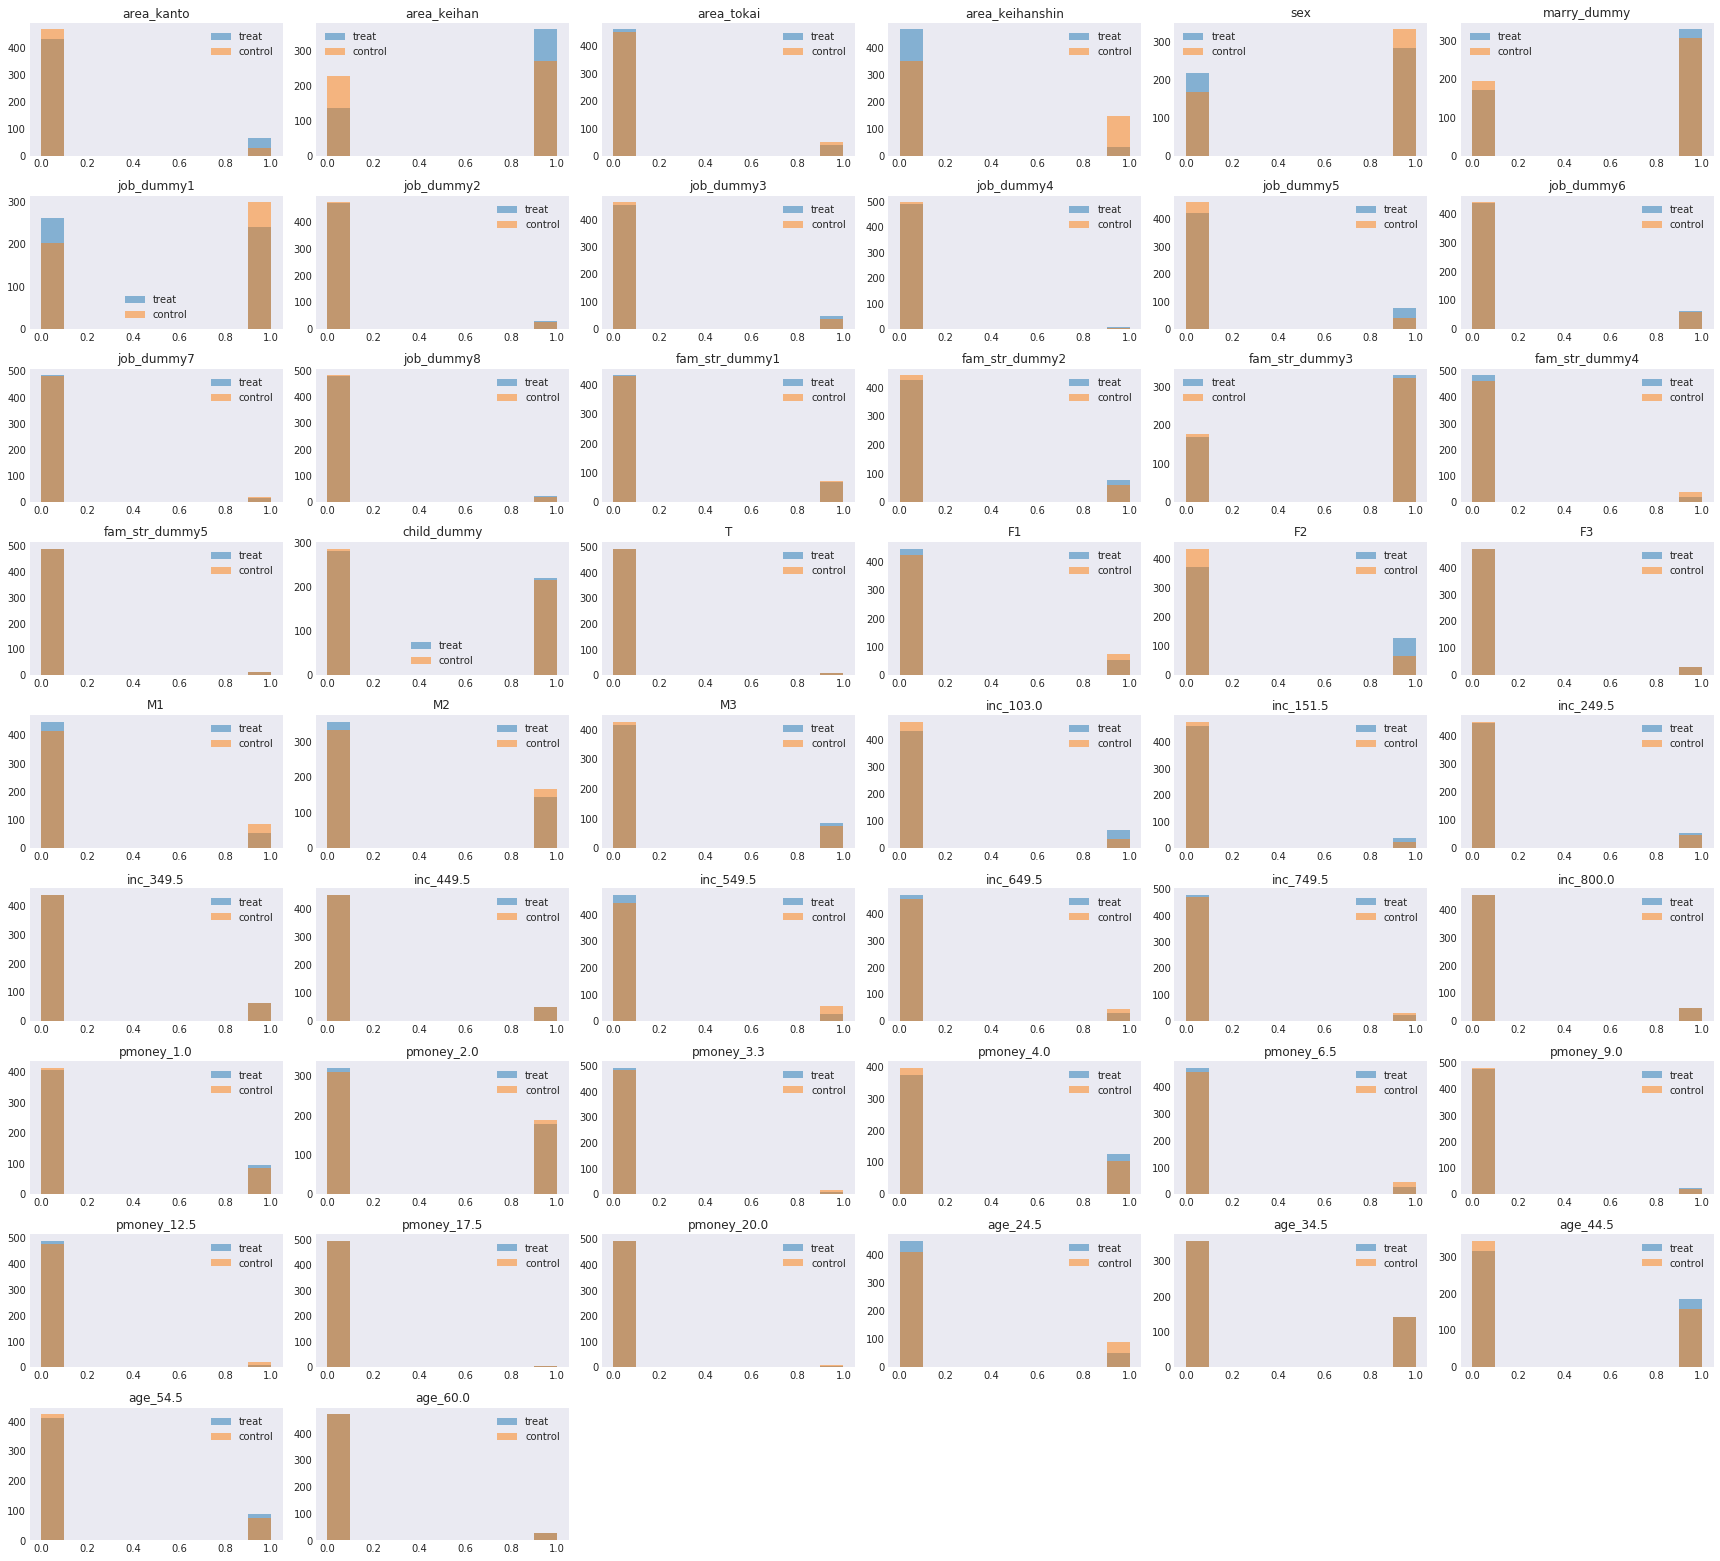

In [11]:
# Check distribution
save_file = os.path.join(save_dir, 'covariate_distribution.png')
show_covariate_distribution(biased_df, t_col=treat_col, cov_cols=cov_cols, save_file=save_file)

# Estimate PS

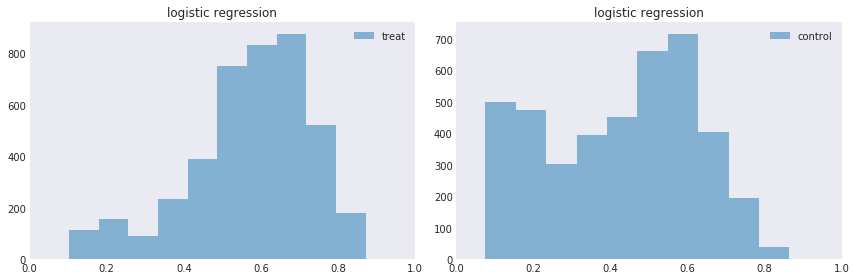

In [12]:
est = EffectEstimatorPS(t_col=treat_col, cov_cols=cov_cols, ps_col=ps_col)

ps_model = LogisticRegression(random_state=123)
biased_df[ps_col] = est.estimate_ps(model=ps_model, df=biased_df)

save_file = os.path.join(save_dir, 'ps_distribution.png')
est.show_ps_distribution(biased_df, title='logistic regression', save_file=save_file)

# IPW
---

In [13]:
# weighting
est = EffectEstimatorPS(t_col=treat_col, cov_cols=cov_cols, ps_col=ps_col, y_col=outcome_col, 
                        method='weighting', weighting_method='att', weight_clipping=True, estimand='average')

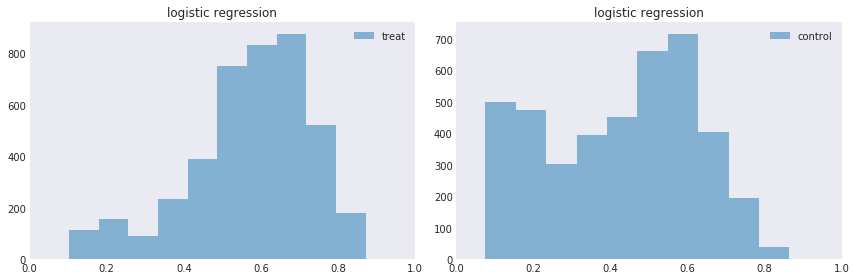

In [14]:
# Estimate propensity score
ps_model = LogisticRegression(random_state=123)
#ps_model = CalibratedClassifierCV(LogisticRegression(random_state=123), cv=3, method='isotonic')
biased_df[ps_col] = est.estimate_ps(model=ps_model, df=biased_df)

est.show_ps_distribution(biased_df, title='logistic regression')


Unadjusted covariates:

Adjusted covariates:


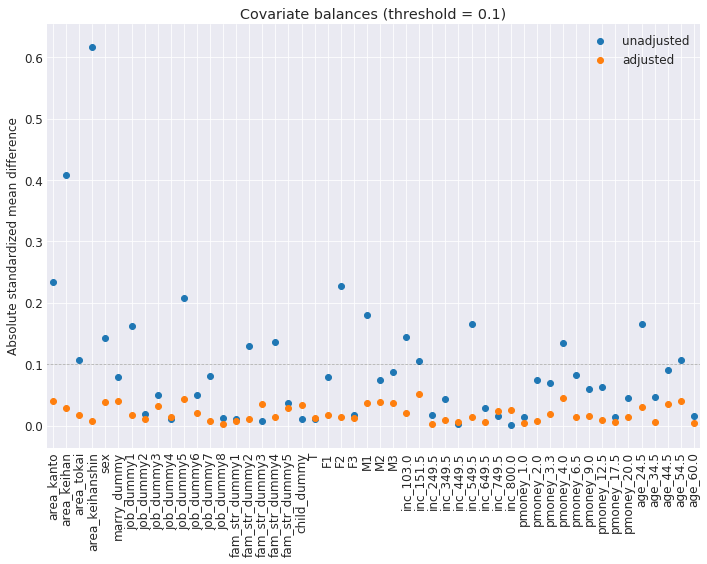

In [15]:
weighted_df = est.adjust(biased_df)

save_file = os.path.join(save_dir, 'covariate_balance_weighting.png')
est.show_covariate_balance(unadjusted_df=biased_df, adjusted_df=weighted_df, save_file=save_file)    # , verbose=True

In [16]:
est.estimate(weighted_df)
print(f'\nATT(weighting): {est.effect_ :.6f}')


IPW estimation(ATT weighting) results:
Treatment outcome: 0.075290
Control outcome:   0.070899
Treatment effect:   0.004391

ATT(weighting): 0.004391


# Matching
---

In [17]:
est = EffectEstimatorPS(t_col=treat_col, cov_cols=cov_cols, ps_col=ps_col, y_col=outcome_col, 
                        method='matching', estimand='average', caliper=0.5)
ps_model = LogisticRegression(random_state=123)
biased_df[ps_col] = est.estimate_ps(model=ps_model, df=biased_df)


ATT matching....
# of matched pairs: 3120 (0.753 of all records)

ATC matching....
# of matched pairs: 2987 (0.721 of all records)

Unadjusted covariates:

Adjusted covariates:


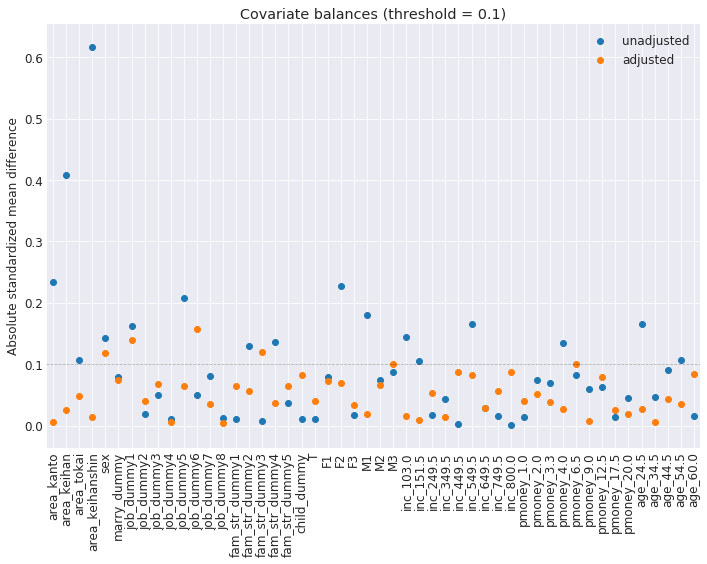

In [18]:
# Adjust confoundedness and check adjusted covariate balance
att_matched_df, atc_matched_df = est.adjust(biased_df)

save_file = os.path.join(save_dir, 'covariate_balance_matching.png')
est.show_covariate_balance(unadjusted_df=biased_df, adjusted_df=att_matched_df, save_file=save_file)  # , verbose=True
#est.show_covariate_balance(unadjusted_df=biased_df, adjusted_df=atc_matched_df)  # , verbose=True

In [19]:
# Estimate effect
est.estimate(att_matched_df)
att = est.effect_
num_treat = est.num_treat_

est.estimate(atc_matched_df)
atc = est.effect_
num_control = est.num_control_

Treatment outcome: 0.076603
Control outcome:   0.081731
Treatment effect:  -0.005128, (p-value=0.453226)
Treatment outcome: 0.105122
Control outcome:   0.079344
Treatment effect:  0.025778, (p-value=0.000573)


In [20]:
print('\nATE results:')
ate = (att * num_treat + atc * num_control) / (num_treat + num_control)
print(f'Treatment effect:  {ate: .6f}')


ATE results:
Treatment effect:   0.009989


In [21]:
print(f'ATT(matching): {att :.6f}')
print(f'ATC(matching): {atc :.6f}')
print(f'ATE(matching): {ate :.6f}')

ATT(matching): -0.005128
ATC(matching): 0.025778
ATE(matching): 0.009989


# Sensitivity analysis
---


Sensitivity analysis, calculating the E-value curve.
Est. risk ratio: 1.0669
E-value:         1.3342


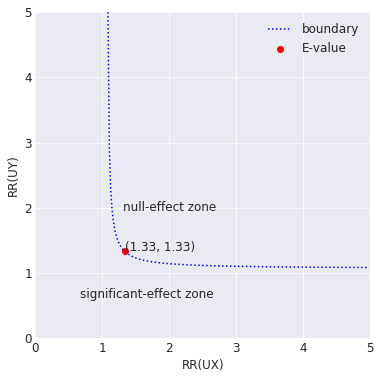

In [22]:
save_file = os.path.join(save_dir, 'sens_curve.png')
sensitivity_analysis(att_matched_df, t_col=treat_col, y_col=outcome_col, save_file=save_file)